In [1]:
import sys
sys.path.append('..')

In [37]:
import pandas as pd
import numpy as np
import numpy.typing as npt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from src.pipeline import preprocessor

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [4]:
# Function to load and split the data
def load_data():
    df = pd.read_csv('../data/Tweets.csv')
    df = df.drop(columns=['tweet_id'])
    df_train, df_test = train_test_split(df, test_size=0.1, stratify=df[['airline_sentiment']], random_state=0)

    X_train = df_train.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_train = df_train[['airline_sentiment']]

    X_test = df_test.drop(columns=['airline_sentiment', 'airline_sentiment_confidence'])
    y_test = df_test[['airline_sentiment']]

    return X_train, y_train, X_test, y_test

In [ ]:
# Load the data
X_train, y_train, X_test, y_test = load_data()

# Apply preprocessing to the training data
X_train_processed = torch.tensor(preprocessor.fit_transform(X_train).toarray(), dtype=torch.float32)
X_test_processed = torch.tensor(preprocessor.transform(X_test).toarray(), dtype=torch.float32)

In [83]:
# Encode target labels
ohe = OneHotEncoder(sparse_output=False)
y_train_ohe = torch.tensor(ohe.fit_transform(y_train), dtype=torch.float32)
y_test_ohe = torch.tensor(ohe.transform(y_test), dtype=torch.float32)

le = LabelEncoder()
y_train_labels = le.fit_transform(y_train.values.flatten())
y_test_labels = le.transform(y_test.values.flatten())

In [ ]:
class FNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fnn = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, output_dim),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, dtype=torch.float)
        x = self.fnn(x)
        return x

In [175]:
def fit_neural_network(
        model, optimizer, criterion,
        X: npt.NDArray, y: npt.NDArray, epochs: int, batch_size: int):
    
    n_batches = np.ceil(len(X) / batch_size).astype(np.int32)
    max_acc = 0.0
    for epoch in range(epochs):
        model.train()
        print(f"epoch {epoch+1}/{epochs}")
        permutation_idx = torch.randperm(X.size(0))
        X_shuffled = X[permutation_idx]
        y_shuffled = y[permutation_idx]

        running_loss = 0.0
        for i in range(0, X.size(0), batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]

            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        # print(f"average loss: {running_loss/n_batches}")

        model.eval()
        y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
        f1s = f1_score(y_test_labels, y_pred, average='weighted')
        acc = accuracy_score(y_test_labels, y_pred)
        print(f"f1: {f1s:.3f}\tacc: {acc:.3f}")
        if acc > max_acc:
            max_acc = acc
            torch.save(model, 'best_model.pt')

        running_loss = 0

In [176]:
model = FNN(X_train_processed.shape[1], 3)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
fit_neural_network(model, optimizer, criterion, X_train_processed, y_train_ohe, epochs=500, batch_size=128)

In [181]:
model = torch.load('../models/model_0.918.pt')
model.eval()
y_pred = np.array(torch.argmax(model(X_test_processed), dim=1))
accuracy_score(y_test_labels, y_pred)

C:\Users\jasie\AppData\Local\Temp\ipykernel_21032\1338973619.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('../models/model_0.918.pt')


0.9180327868852459

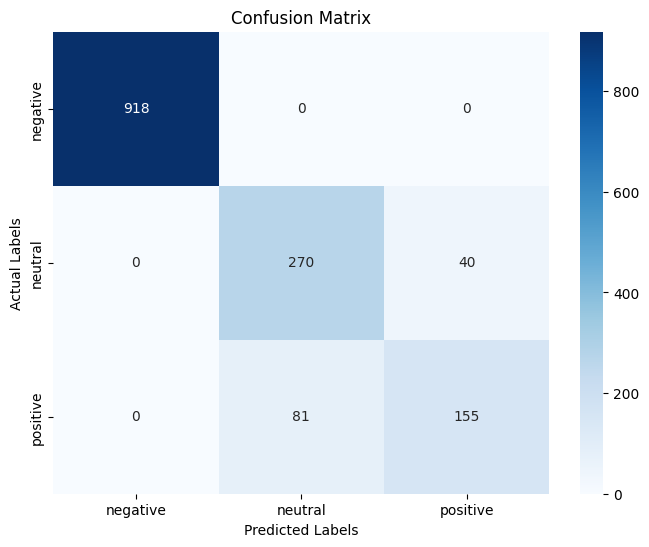

In [179]:
# Generating a confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Visualizing the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')
plt.show()